### An example - _PIV data_

Here we have several experimental results of velocities at each timestep, with parameters :
- The input voltage of the motor ```u``` 
- The height of the tunnel's floor ```h```
- ...

### First we import our modules

In [42]:
import glob
from natsort import natsorted

import numpy as np 
import matplotlib.pyplot as plt

%matplotlib widget

### ...Then look into the data

In [43]:
ROOT = './example_1/step1_fps90_u5'

frames = natsorted(glob.glob(f'{ROOT}/frames/*.npy')) # get all frame paths, sorted

print("\n".join(frames[:10]))


./example_1/step1_fps90_u5/frames/frame_0.npy
./example_1/step1_fps90_u5/frames/frame_1.npy
./example_1/step1_fps90_u5/frames/frame_2.npy
./example_1/step1_fps90_u5/frames/frame_3.npy
./example_1/step1_fps90_u5/frames/frame_4.npy
./example_1/step1_fps90_u5/frames/frame_5.npy
./example_1/step1_fps90_u5/frames/frame_6.npy
./example_1/step1_fps90_u5/frames/frame_7.npy
./example_1/step1_fps90_u5/frames/frame_8.npy
./example_1/step1_fps90_u5/frames/frame_9.npy


In [44]:
ux, uy = np.load(frames[100])

print(ux.shape)
print(uy.shape)

(106, 202)
(106, 202)


Let's get a quick look at what the velocity data look like...

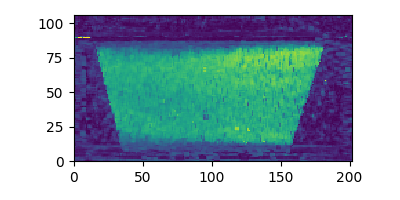

In [45]:
fig, ax = plt.subplots(figsize=(4, 2)) 

ax.pcolormesh(np.sqrt(ux ** 2 + uy ** 2), vmin=0, vmax=0.1)
ax.axis('scaled');

plt.tight_layout()

... the metadata, ...

In [46]:
import pickle, yaml

with open(f'{ROOT}/step1_fps90_u5_metadata', 'rb') as file: 
    metadata = pickle.load(file)
    
print(yaml.dump(metadata))

day: '230105'
dt: 0.002108814846056516
fps: 474.2
gaussfilt_sig: 0.01
medfilt_size: 1
n_frames: 474
overlap: 24
pxlperm: 6300
s2n_t: 2
s2n_w: 20
searchsize: 34
step: 1
voltage: 5
winsize: 34



... and the space coordinates

In [47]:
x, y = np.load(f'{ROOT}/coords.npy')

print(x.shape) 
print(y.shape) 

print('\n')
print(f'Max of x: {np.max(x):.3f} m')
print(f'Max of y: {np.max(y):.3f} m')

(106, 202)
(106, 202)


Max of x: 0.322 m
Max of y: 0.170 m


# Here comes Xarray's magic

A bit painful to create, true, but it is worth it


First, for the coordinates, we create a ```coords_dict``` dictionary

In [48]:
coords_dict = dict(
    
    x = ('x', np.unique(x)),
    y = ('y', np.unique(y)),
    
    time = ('time', np.arange(metadata['n_frames']) * metadata['dt']),
    
    height = ('height', [metadata['step']]),
    date = ('date', [metadata['day']]),
    voltage = ('voltage', [metadata['voltage']])
    
    )

Then, the data

First we load everything, ...

In [49]:
U = np.array([np.load(frame) for frame in frames])

print(f'Shape of U: {U.shape} > (time, direction, y, x)')

ux, uy = U[:, 0], U[:, 1]

Shape of U: (474, 2, 106, 202) > (time, direction, y, x)


... We compute some interesting stuff, ...

In [50]:
curl = np.gradient(uy, axis=2) - np.gradient(ux, axis=1)
div  = np.gradient(ux, axis=2) + np.gradient(uy, axis=1)
vel  = np.sqrt(ux ** 2 + uy ** 2)

... And we create a data dictonary ```data_dict```, like this :

In [51]:
data_dict = dict(
    
    ux = (['time', 'y', 'x'], ux), #{"units": "m*s**(-1)"}), # >>> even better : (['time', 'y', 'x'], ux.astype(float32))
    uy = (['time', 'y', 'x'], uy), #{"units": "m*s**(-1)"}),

    vel  = (['time', 'y', 'x'], vel), #{"units": "m*s**(-1)"}),

    curl = (['time', 'y', 'x'], curl), #{"units": "s**(-1)"}),
    div  = (['time', 'y', 'x'], div),  #{"units": "s**(-1)"}),

    )

## Now we are ready to create our DataSet

In [70]:
import xarray as xr

ds = xr.Dataset(data_vars=data_dict, coords=coords_dict, attrs=metadata)
print(ds)

ds.to_netcdf('example_1/example_ds.nc')

ds.attrs

<xarray.Dataset>
Dimensions:  (time: 474, y: 106, x: 202, height: 1, date: 1, voltage: 1)
Coordinates:
  * x        (x) float64 0.003016 0.004603 0.00619 ... 0.3189 0.3205 0.3221
  * y        (y) float64 0.003016 0.004603 0.00619 ... 0.1665 0.1681 0.1697
  * time     (time) float64 0.0 0.002109 0.004218 ... 0.9933 0.9954 0.9975
  * height   (height) int64 1
  * date     (date) <U6 '230105'
  * voltage  (voltage) int64 5
Data variables:
    ux       (time, y, x) float64 -0.001486 -0.000975 ... 0.004087 0.000793
    uy       (time, y, x) float64 0.007555 0.008471 0.004829 ... -0.0 0.004438
    vel      (time, y, x) float64 0.0077 0.008527 0.005604 ... 0.004087 0.004509
    curl     (time, y, x) float64 -0.0002456 -0.003169 ... 0.009424 0.009993
    div      (time, y, x) float64 0.003526 0.001746 ... -0.005537 0.0005421
Attributes: (12/14)
    step:           1
    voltage:        5
    n_frames:       474
    fps:            474.2
    dt:             0.002108814846056516
    day:        

{'step': 1,
 'voltage': 5,
 'n_frames': 474,
 'fps': 474.2,
 'dt': 0.002108814846056516,
 'day': '230105',
 'searchsize': 34,
 'winsize': 34,
 'overlap': 24,
 's2n_w': 20,
 's2n_t': 2,
 'medfilt_size': 1,
 'gaussfilt_sig': 0.01,
 'pxlperm': 6300}

It's done ! Let's see what we can do with it now...

### A quick plot 
one line (!), easy to understand/read (good if you leave your code for a few weeks) & easy to adapt 

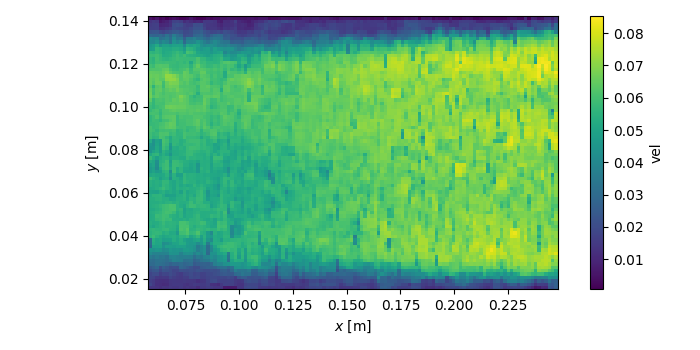

In [57]:
ds = xr.open_dataset('example_1/example_ds.nc')

time_idx = 200

ds_ = ds.isel(x=slice(35, 155), y=slice(8, 88)) #to keep only a region of interest in the images
ds_ = ds_.isel(time=time_idx)

fig, ax = plt.subplots(figsize=(7, 3.5)) 


####
variable = 'vel'
pcm = ax.pcolormesh(ds_.x, ds_.y, abs(ds_[variable]))
####

ax.axis('scaled');
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
cbar = fig.colorbar(pcm)
cbar.set_label(variable, rotation=90)
fig.tight_layout()

## But it is getting even better !
Now imagine you have several experiments in different ```.nc``` files 

In [61]:
paths = natsorted(glob.glob('example_1/datasets_example/*.nc'))
 

In [63]:
ds = xr.open_mfdataset(paths, combine='by_coords', combine_attrs='drop_conflicts')
print(ds)


<xarray.Dataset>
Dimensions:  (x: 120, y: 80, time: 475, date: 1, height: 2, voltage: 8)
Coordinates:
  * x        (x) float64 0.05857 0.06016 0.06175 ... 0.2443 0.2459 0.2475
  * y        (y) float64 0.01571 0.0173 0.01889 0.02048 ... 0.1379 0.1395 0.1411
  * time     (time) float64 0.0 90.0 180.0 ... 4.248e+04 4.257e+04 4.266e+04
  * date     (date) object '230105'
  * height   (height) int64 1 2
  * voltage  (voltage) int64 5 6 7 8 9 10 11 12
Data variables:
    ux       (voltage, height, time, y, x) float64 dask.array<chunksize=(1, 1, 475, 80, 120), meta=np.ndarray>
    uy       (voltage, height, time, y, x) float64 dask.array<chunksize=(1, 1, 475, 80, 120), meta=np.ndarray>
    v        (voltage, height, time, y, x) float64 dask.array<chunksize=(1, 1, 475, 80, 120), meta=np.ndarray>
    curl     (voltage, height, time, y, x) float64 dask.array<chunksize=(1, 1, 475, 80, 120), meta=np.ndarray>
    div      (voltage, height, time, y, x) float64 dask.array<chunksize=(1, 1, 475, 80, 12

Imagine you have :
- 2 heights ```h``` (1, 2) 
- 8 voltages ```u``` (5V - 12V) 

You want to plot the average value of velocity in a region of interest, with respect to voltage, for ```h = 1```
# Before

In [64]:
ns_frames=[412,427,432,453,444,472,468,431,419,436] ## ?
pxlperm= 6300 # not sure about this one because maybe I moved the camera inbetween experiments 
curls= []
vels= []
divs=[]
for height in [1,1,2,2,2,2,2,2,2,2]:
    for i_exp, voltage in enumerate([5,6,5,6,7,8,9,10,11,12]):
        for i_frame in range(ns_frames[i_exp]):
            frame='example_1/step'+str(height)+'_fps90_u'+str(voltage)+'/frames/frame_'+str(i_frame)+'.npy'
            data=np.load(frame)
            ux=data[:,0]
            uy =data[:,1]
            n_y=np.shape(ux)[0]
            n_x=np.shape(ux)[1]
            x=np.linspace(0,n_x*pxlperm,n_x)
            y =np.linspace(0,n_y*pxlperm, n_y)
            curl= np.gradient(uy,axis=1)-np.gradient(ux,axis=0)
            vel=np.sqrt(ux**2+ uy**2)
            curls.append(curl)
            vels.append(vel)
            
avg_vels_cropped = []
for i in range(len(vels)):
    avg_vel=np.mean(curls[i][ROI[0]:ROI[1],ROI[2]:ROI[3]])
    avg_vels_cropped.append(avg_vel)

heights = [1,1,2,2,2,2,2,2,2,2]
avg_vels_cropped_h2=avg_vels[heights==2]
voltages_h2=voltages[heights==2]

FileNotFoundError: [Errno 2] No such file or directory: 'example_1/step1_fps90_u6/frames/frame_0.npy'

# After

In [68]:
paths = natsorted(glob.glob('example_1/datasets_example/*.nc'))

ds = xr.open_mfdataset(paths, combine='by_coords', combine_attrs='drop')


{}

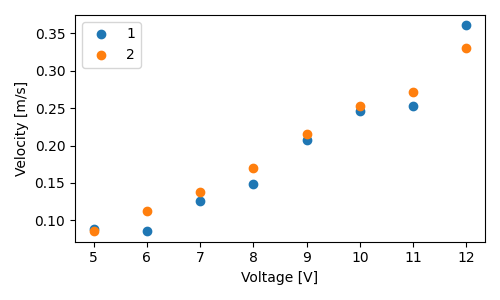

In [67]:
ROI = [(0.1, 0.2), (0.04, 0.12)] #in meter

ds_ = ds.sel(x=slice(*ROI[0]), y=slice(*ROI[1])).squeeze()
fig, ax = plt.subplots(figsize=(5, 3))

###
ax.plot(ds.voltage, ds_.v.mean(dim=['time', 'x', 'y']), 'o', label=ds.height.values);
###

ax.set_xlabel('Voltage [V]');
ax.set_ylabel('Velocity [m/s]');
ax.legend() 

fig.tight_layout()




In [ ]:
ds_.v

## Useful functions 

- ```.isel()``` and ```.sel()``` to index variables 

```
    ds.nat_freq.sel(specimen='A0.1')
    ds.Kr.isel(time=slice(0, 100)) 
```
- ```.mean(dim=_)``` (same with ```std```, ```min```, ```max```, ```sum```, ```median```, etc...)


- ```.where(condition, drop=True)```, for example ```ds.where(ds.date>'2023-01-12', drop=True)``` 


- ```groupby_bins``` if you have a parameter whose values are close but not exactly the same (typically measured parameter) > *Tristan*
```
    omega_bins = np.linspace(ds.omega.min(), ds.omega.max(), num=10) 
    ds_binned = ds.groupby_bins(group='omega', bins=omega_bins).mean()
```

# Conclusion

### Good points 
- Does not load all the data into memory - _lazy maps_ 
- Easy to write, understand code
- Auto-fill where data does not align 
- Store metadata attributes (```attrs```)
- Operations similar to numpy
- easy to share 
- can be opened in parallel
- golden-standard in geoscience

### Bad point
- Complicated to setup at first

#### It a bit difficult to implement at first, but then you gain a lot of time 

#### If you wan to give it a go > ```https://tutorial.xarray.dev/overview/xarray-in-45-min.html``` + I can help you :)

## In any case, thanks for listening

## ressources 